# Ансамбли моделей машинного обучения.

Цель лабораторной работы: изучение ансамблей моделей машинного обучения.

In [4]:
# импортируем нужные для анализа библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline 
sns.set(style="ticks")

## Загрузка данных

Используем датасет по характеристикам бриллиантов [Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds).

In [5]:
# Импортируем датасет
data = pd.read_csv('data/diamonds.csv', sep=",")
data = data.set_index("Unnamed: 0")
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
# типы колонок
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

Заменяем категориальные столбцы на числовые (оптимально, так как cut, color и clarity, по сути, тоже шкалы, только не числовые):

In [7]:
data['cut_num'] = data['cut'].apply(lambda x: ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'].index(x))
data['color_num'] = data['color'].apply(lambda x: ['D', 'E', 'F', 'G', 'H', 'I', 'J'].index(x))
data['clarity_num'] = data['clarity'].apply(lambda x: ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3'].index(x))
data.pop('cut')
data.pop('color')
data.pop('clarity')
data.head()

,carat,depth,table,price,x,y,z,cut_num,color_num,clarity_num
Unnamed: 0,,,,,,,,,,
1,0.23,61.5,55.0,326,3.95,3.98,2.43,4,1,7
2,0.21,59.8,61.0,326,3.89,3.84,2.31,3,1,6
3,0.23,56.9,65.0,327,4.05,4.07,2.31,1,1,4
4,0.29,62.4,58.0,334,4.20,4.23,2.63,3,5,5
5,0.31,63.3,58.0,335,4.34,4.35,2.75,1,6,7


In [8]:
# Выделяем классифицирующий параметр, делим выборку на обучающую и тестовую
data_target = data.pop("price")
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data, data_target, test_size=0.3, random_state=1)

In [9]:
# размер набора данных
data_x_train.shape, data_y_train.shape, data_x_test.shape, data_y_test.shape

((37758, 9), (37758,), (16182, 9), (16182,))

In [10]:
type(data_x_train), type(data_y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [11]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO 

In [12]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

# Обучение модели случайного леса
Обучим модель случайного леса. Для этого, обучим L деревьев для составления ансамбля. Выборки для них получим путём бэггинга из изначальной. Также, ограничим число признаков в каждом дереве случайно выбранной третью от изначальных.
После этого, для предсказывания целевого признака (регрессионного) исходные данные проходят через каждое дерево и вычисляется среднее арифметическое от предсказаний каждого дерева.

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
# Обучим регрессор на 5 деревьях
tree1 = RandomForestRegressor(n_estimators=5, oob_score=True, random_state=10, max_features=float(1)/3, max_depth=3)
tree1.fit(data_x_train, data_y_train)

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(max_depth=3, max_features=0.3333333333333333,
                      n_estimators=5, oob_score=True, random_state=10)

In [15]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.6779497307258485, 0.3220502692741515)

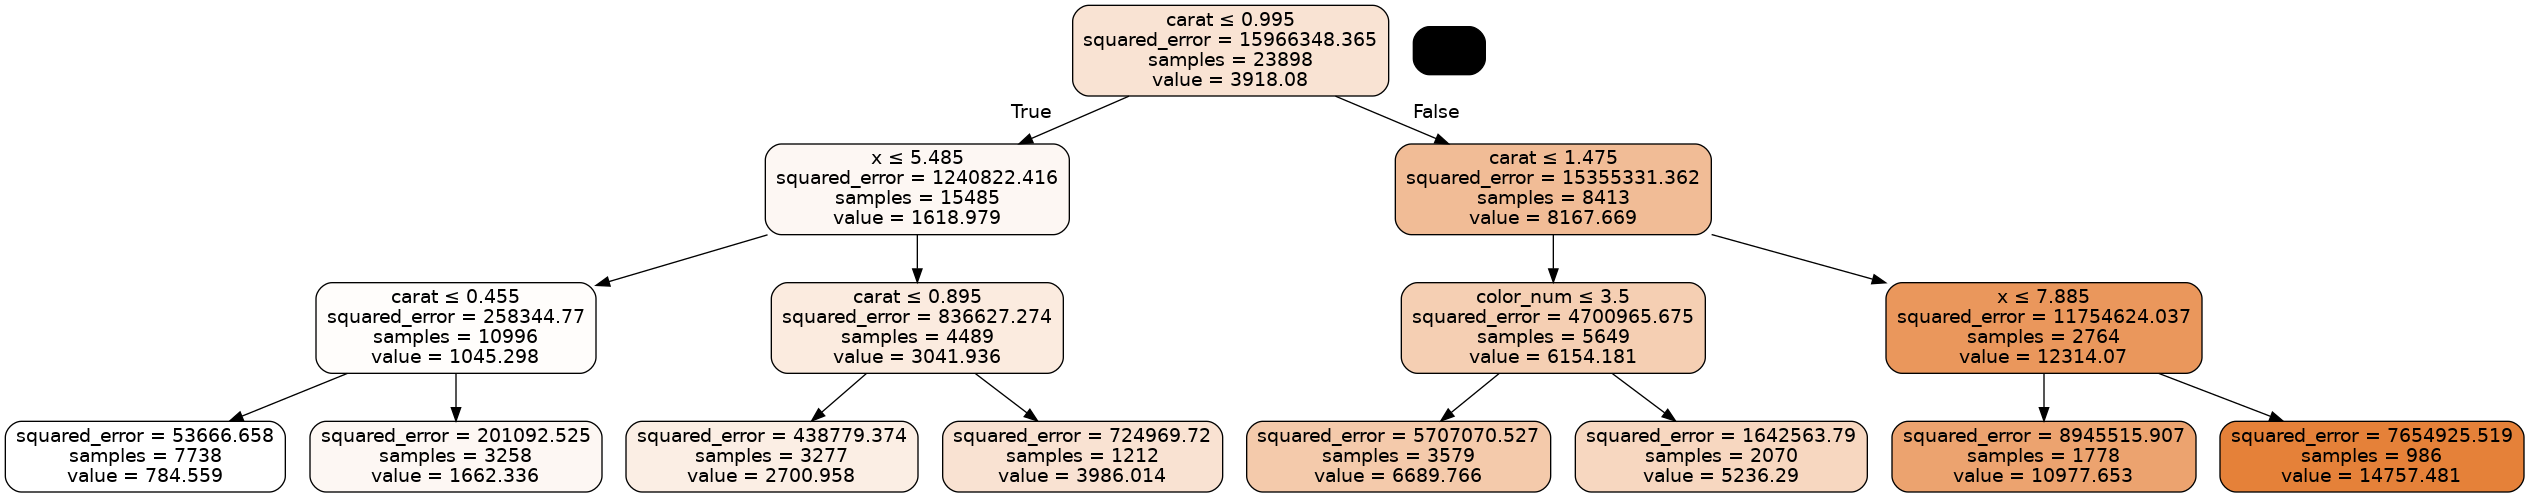

In [16]:
Image(get_png_tree(tree1.estimators_[0], data_x_train.columns), width="500")

Обучим "большой" лес и посмотрим его характеристики:

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
for n_estimators in range(10, 100, 5):
    # Обучим регрессор на 100 деревьях
    tree2 = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=10, n_jobs=-1, max_features=float(1)/3)
    tree2.fit(data_x_train, data_y_train)
    score = tree2.score(data_x_test, data_y_test)
    tree_pred_y2 = tree2.predict(data_x_test)
    mse = mean_squared_error(data_y_test, tree_pred_y2)   
    print("Random forest: Trees: {0}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(n_estimators, score, mse, np.sqrt(mse)))

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 10, R2:0.98, MSE:339947.34, RMSE:583.05


/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 15, R2:0.98, MSE:325004.77, RMSE:570.09


/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 20, R2:0.98, MSE:317414.56, RMSE:563.40


/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 25, R2:0.98, MSE:309792.56, RMSE:556.59


/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 30, R2:0.98, MSE:306743.30, RMSE:553.84


/home/mikhail/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Random forest: Trees: 35, R2:0.98, MSE:305137.35, RMSE:552.39
Random forest: Trees: 40, R2:0.98, MSE:304012.27, RMSE:551.37
Random forest: Trees: 45, R2:0.98, MSE:301885.42, RMSE:549.44
Random forest: Trees: 50, R2:0.98, MSE:300783.35, RMSE:548.44
Random forest: Trees: 55, R2:0.98, MSE:300765.55, RMSE:548.42
Random forest: Trees: 60, R2:0.98, MSE:299547.36, RMSE:547.31
Random forest: Trees: 65, R2:0.98, MSE:297936.40, RMSE:545.84
Random forest: Trees: 70, R2:0.98, MSE:297295.21, RMSE:545.25
Random forest: Trees: 75, R2:0.98, MSE:297205.63, RMSE:545.17
Random forest: Trees: 80, R2:0.98, MSE:296318.88, RMSE:544.35
Random forest: Trees: 85, R2:0.98, MSE:296578.68, RMSE:544.59
Random forest: Trees: 90, R2:0.98, MSE:295845.88, RMSE:543.92
Random forest: Trees: 95, R2:0.98, MSE:295728.10, RMSE:543.81


Как видно, метод случайного леса показывает себя гораздо лучше, чем просто метод случайного дерева из 4-1 лабораторной. При этом, при росте количества деревьев не наблюдается серьёзного улучшения модели.

# Бустинг
При бустинге в отличие от бэггинга на входы обучающихся подмоделей (например, деревьев) приходит не только выборка из бутстрэпа , но и результат на выходе предыдущей модели. При этом, те примеры, которые предыдущая модель предсказала неверно (или сильно ошиблась в случае регрессии) имеют больший вес, чем предсказанные верно (точно), что позволяет уменьшить итоговое смещение, "равномерно" предсказывая результат.
Итоговый регрессор получается, в отличие от бэггинга, с помощью взвешенного среднего внутренних: чем точнее внутренний регрессор, тем больше его вес.

Будем использовать библиотеку CatBoost:
https://yandex.ru/dev/catboost/

In [19]:
from catboost import CatBoostRegressor, Pool

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [20]:
for n_iterations in range(5, 100, 5):
    catboost_pred = CatBoostRegressor(iterations=n_iterations,
                                    learning_rate=1, 
                                    loss_function='RMSE',
                                    verbose = False)
    catboost_pred.fit(data_x_train, data_y_train)
    score = catboost_pred.score(data_x_test, data_y_test)
    tree_pred_y2 = catboost_pred.predict(data_x_test)
    mse = mean_squared_error(data_y_test, tree_pred_y2)
    print("Boosting: Iterations:{0}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(n_iterations, score, mse, np.sqrt(mse)))

Boosting: Iterations:5, R2:0.96, MSE:638920.10, RMSE:799.32
Boosting: Iterations:10, R2:0.97, MSE:452849.71, RMSE:672.94
Boosting: Iterations:15, R2:0.97, MSE:407620.96, RMSE:638.45
Boosting: Iterations:20, R2:0.98, MSE:360493.21, RMSE:600.41
Boosting: Iterations:25, R2:0.98, MSE:344130.86, RMSE:586.63
Boosting: Iterations:30, R2:0.98, MSE:335404.71, RMSE:579.14
Boosting: Iterations:35, R2:0.98, MSE:322506.62, RMSE:567.90
Boosting: Iterations:40, R2:0.98, MSE:318023.76, RMSE:563.94
Boosting: Iterations:45, R2:0.98, MSE:313177.24, RMSE:559.62
Boosting: Iterations:50, R2:0.98, MSE:312910.41, RMSE:559.38
Boosting: Iterations:55, R2:0.98, MSE:309202.54, RMSE:556.06
Boosting: Iterations:60, R2:0.98, MSE:309242.10, RMSE:556.10
Boosting: Iterations:65, R2:0.98, MSE:309199.17, RMSE:556.06
Boosting: Iterations:70, R2:0.98, MSE:308625.93, RMSE:555.54
Boosting: Iterations:75, R2:0.98, MSE:308303.94, RMSE:555.25
Boosting: Iterations:80, R2:0.98, MSE:307204.32, RMSE:554.26
Boosting: Iterations:85, 

Как видно, в результате бустинга получилась сопоставимая по характеристикам с бэггингом модель.

# Стекинг
В стекинге подсчёт итогового результата на основе выходов подмоделей является самостоятельной машинной моделью. Также, в отличие от бэггинга и бустинга, подмодели могут быть любыми, не обязательно одинаковыми по сути, вроде деревьев.

Если проще, входные данные прогоняют через несколько разных моделей, а их выходы - через ещё одну модель, получая таким образом итоговое предсказание.


In [21]:
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [23]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(data_x_train, data_y_train)
    y_pred = model.predict(data_x_test)
    result = mean_squared_error(data_y_test, y_pred)
    print(model)
    print('MSE={}'.format(result))

In [24]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression()
MSE=1399641.5540963497

DecisionTreeRegressor()
MSE=550269.505778025

RandomForestRegressor(n_estimators=50)
MSE=286284.52628465655



In [25]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(data_x_train, data_y_train, data_x_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [26]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_squared_error)

Metric: mean_squared_error
Folds accuracy: [539592.4425949196, 539059.4389763844, 546597.8114816041, 570207.0515584503, 472143.8994352887, 544636.7551988685, 565951.8713898156, 489749.51211939653, 466276.35092249914, 479779.65208635747]
Mean accuracy: 521399.4785763584
Standard Deviation: 37925.5608338269
Variance: 1438348164.560305


In [27]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_squared_error)

Metric: mean_squared_error
Folds accuracy: [518495.86754952685, 488916.5794703522, 477214.78019917797, 498216.82218990807, 502708.069602381, 505871.2075780342, 540419.0314953118, 476702.09187120025, 465725.74485661363, 455498.7414459212]
Mean accuracy: 492976.8936258427
Standard Deviation: 24222.772319074404
Variance: 586742698.8217171


In [28]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
# Результат лучше, чем в эксперименте 2
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_squared_error)

Metric: mean_squared_error
Folds accuracy: [324078.90676383, 313815.6862395029, 329487.89941196557, 336977.3747044658, 292383.96016018227, 317622.2520384076, 315364.823723952, 298936.1160475956, 300765.4766520345, 272479.29822608555]
Mean accuracy: 310191.1793968022
Standard Deviation: 18255.575809896884
Variance: 333266048.15089226


In [29]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_squared_error)

Metric: mean_squared_error
Folds accuracy: [358681.72261364263, 328491.59957480116, 386968.9849479004, 363256.09732820943, 321669.07977634645, 358147.49701108545, 339722.91495295614, 315835.47940091573, 323481.1948745053, 303611.2445944906]
Mean accuracy: 339986.5815074853
Standard Deviation: 24647.00267422362
Variance: 607474740.8231863


In [30]:
array_labels = ['LR','TREE', 'RF',
                'TREE+LR=>LR', 'TREE+LR=>RF', 'TREE+LR+RF=>LR',
                'TREE+LR+RF=>RF']
array_mae = [1399641.5540963497, 544230.8937622736, 288776.74350175087,
             521399.4785763584, 492976.8936258427, 310191.1793968022, 
             339986.5815074853]

In [31]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

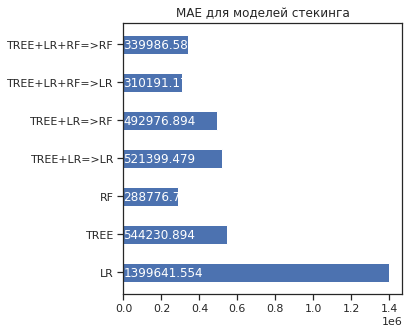

In [32]:
vis_models_quality(array_mae, array_labels, 'MAE для моделей стекинга')

Как видно, модель, включающая в себя только случайный лес, показала лучшие результаты, чем прочие модели и их комбинации. Это логично, учитывая очень большую разницу в эффективности трёх моделей первого уровня, использованных при обучении.

# МГУА

In [38]:
from gmdhpy import gmdh

In [58]:
gmdh_model = gmdh.Regressor(
    ref_functions=('linear_cov', 'quadratic', 'cubic', 'linear'),
    stop_train_epsilon_condition = 0.0001)
gmdh_model.fit(data_x_train.values, data_y_train.values)
y_pred = gmdh_model.predict(data_x_test.values)
result = mean_squared_error(data_y_test, y_pred)
print('MSE={}'.format(result))

train layer0 in 10.79 sec
train layer1 in 18.46 sec
train layer2 in 23.91 sec
train layer3 in 32.01 sec
train layer4 in 15.60 sec
train layer5 in 12.70 sec
train layer6 in 9.27 sec
train layer7 in 8.89 sec
train layer8 in 7.80 sec
train layer9 in 6.22 sec
train layer10 in 14.33 sec
train layer11 in 8.02 sec
train layer12 in 11.75 sec
train layer13 in 6.31 sec
train layer14 in 6.55 sec
train layer15 in 6.74 sec
MSE=628331.0706630665


# Вывод
Лучше всего себя показала модель случайного леса - она дала самые небольшие показатели MSE по сравнению с остальными. В случае линейной регрессии нелинейные зависимости из изначального датасета аппроксимировались до линейных, что дало большую ошибку. В случае же одного случайного дерева, возможно, итоговая регрессия получалась слишком "грубой", а использование множества различных деревьев позволило "сгладить" этот недостаток.